In [2]:
import importlib
import numpy as np
from matplotlib import pyplot as plt
import MEVeS as S
importlib.reload(S)
import AtomicConstants as AC
importlib.reload(AC)
import Optimiser as Opt
importlib.reload(Opt)
from scipy.optimize import curve_fit

In [3]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 2}, "intermediate": {"n": 5, "J": 3/2}, 
                                                    "storage": {"n" : 4, "L": 2, "J" : 5/2}}}
atom = AC.Rb87(config)

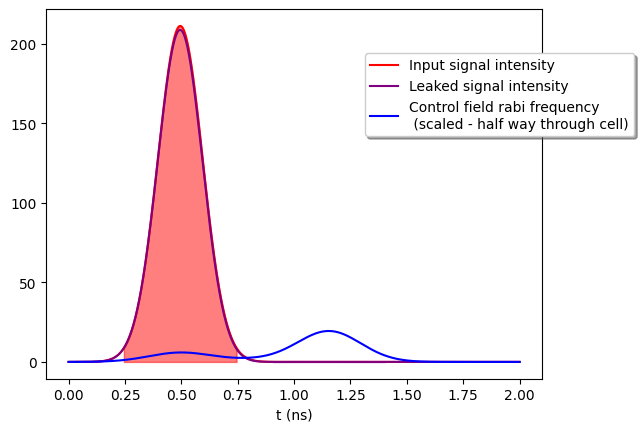

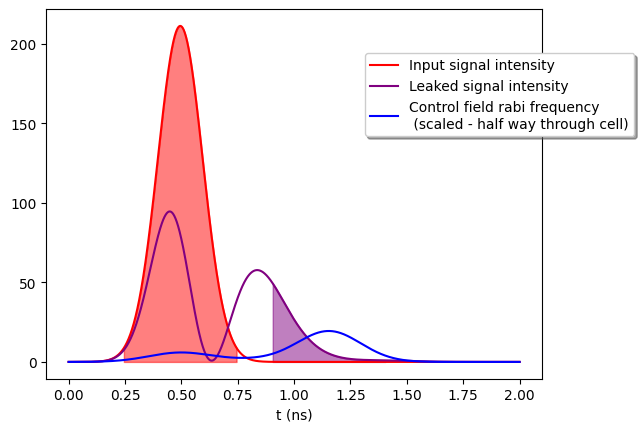

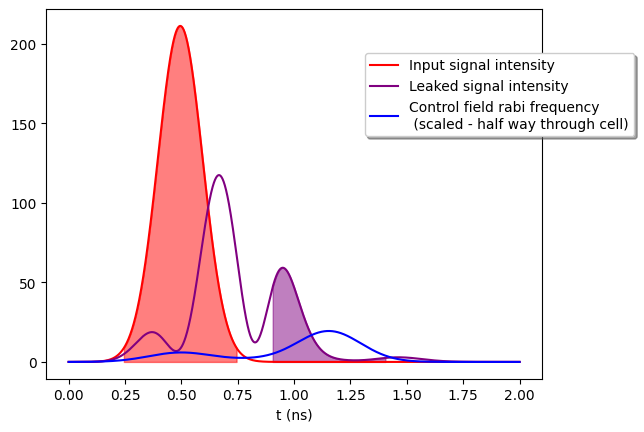

In [15]:
protocol = 'ORCA'
OD_factor = 0.4567
control_factor = 1/6

T = 273.15 + 100
L = 0.075

OD = 10000 #OD_factor*optical_depth(atom, T, L)

tau = 330e-12
n = 75

vno = 30
detuning = 2*np.pi*6e9

deltaS = -detuning 
deltaC = detuning

t0 = 1.5*tau
tend = 2e-9
tbounds = np.array([0, tend])

m = 4000
t = np.linspace(0, tend, m)

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :]

# Coherence S_gs
Sinits = np.zeros((n, 1, 1, 1, 1, vno)) 


control_pol = np.array([1, 0])


Omega_list = 2*np.pi*1e9 * np.linspace(0.5, 10, 3)
R = 3.3 # ratio of retireval control pulse energy to storage control pulse energy

tr = 660e-12
tw = 500e-12

readin_list = []
readout_list = []
energy_list_store = []
energy_list_retrieve = []

for Omega in Omega_list:

    sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    sol.gammaS = 1/84e-9
    sol.gammaSNU = sol.gammaS/sol.gamma

    # norm_coherence = np.trapz(Sinits[:, 0, 0, 0, 0, 0]**2, x=sol.zCheby)

    Control_store = np.sqrt(S.gaussian(t, t0, tau, Omega**2))
    Control_retrieve = np.sqrt(S.gaussian(t, t0+tr, tau, R*Omega**2))
    energy_list_store.append(atom.control_pulse_to_energy(Control_store, t, r=110e-6, index=0))
    energy_list_retrieve.append(atom.control_pulse_to_energy(Control_retrieve, t, r=110e-6, index=0))
    
    # Control field in time and polarisation
    Control_tp = ((Control_store + Control_retrieve)*control_factor)[:, None] * control_pol[None, :]
    # Control field in time, polarisation and position z
    Control_tzp = sol.counter_prop( Control_tp, zdef=0.5, field=0)

    sol.solve(Control_tzp, method='RK4-Ralston')

    readin_window = [t0-tw/2, t0+tw/2]
    #readout_window = [t0+tr-400e-12*gamma, t0+tr+100e-12*gamma]
    readout_window = [t0+tr-tw/2, t0+tr+tw/2]
    readin_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readin_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readin_window[1]))]
    readout_window_index = [min(range(len(t)), key=lambda i:abs(t[i]-readout_window[0])),
                          min(range(len(t)), key=lambda i:abs(t[i]-readout_window[1]))]
    
    norm = np.trapz( pow(np.abs(sol.E[:, 0, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )
    
    stored = 1-np.trapz( pow(np.abs(sol.E[:, -1, 0])[readin_window_index[0]:readin_window_index[1]], 2), 
                    x=sol.tpoints[readin_window_index[0]:readin_window_index[1]] )/norm
    
    total = np.trapz( pow(np.abs(sol.E[:, -1, 0])[readout_window_index[0]:readout_window_index[1]], 2), 
                    x=sol.tpoints[readout_window_index[0]:readout_window_index[1]] )
    
    retrieved = total/stored
    
    readin_list.append(stored)
    readout_list.append(total)

    plt.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), color='red', label='Input signal intensity')
    plt.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), color='purple', label='Leaked signal intensity')
    plt.plot(t*1e9, (pow(max(np.abs(sol.E[:, 0, 0])), 2)/Omega**2)*pow(Control_tp[:, 0],2), color='blue', label='Control field rabi frequency\n (scaled - half way through cell)')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2), where=(t < readin_window[1]) & (t > readin_window[0]), 
                 alpha=0.5, color='red')
    plt.fill_between(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2), where=(t < readout_window[1]) & (t > readout_window[0]), 
                 alpha=0.5, color='purple')
    plt.xlabel('t (ns)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9), fancybox=True, shadow=True)
    plt.show()

In [22]:
readin_list

[0.014339235706913311, 0.6005023981691936, 0.5802125258727362]

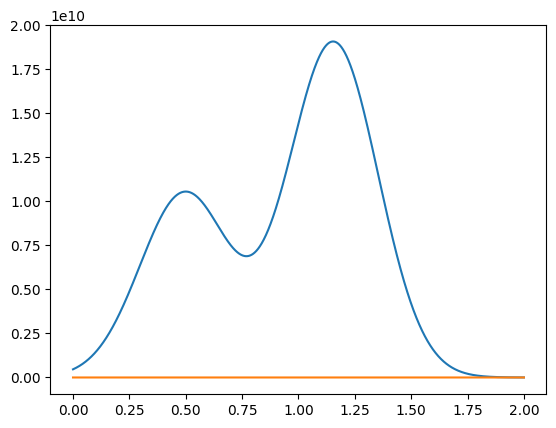

In [30]:
plt.plot(t*1e9, Control_tp[:,0])